In [11]:
import pillow_heif
import utils
import torch
import math
import numpy as np 
from PIL import Image
import cv2
import os
from pathlib import *
import shutil
import pandas as PD
import matplotlib.pyplot as plt
%matplotlib inline
PD.options.display.expand_frame_repr = False

In [2]:
display = utils.notebook_init() 
print('cuda доступна', torch.cuda.is_available())
print('под каким номером куда:',torch.cuda.current_device())
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #без этого ошибка будет

YOLOv5  2022-8-24 Python-3.8.13 torch-1.11.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


Setup complete  (16 CPUs, 39.3 GB RAM, 241.4/953.9 GB disk)
cuda доступна True
под каким номером куда: 0


In [3]:

#функция крутит картинку в зависимости от того, что нашла в характеристиках файла. 
def exif_transpose(img):
    if not img:
        return img

    exif_orientation_tag = 274

    # Check for EXIF data (only present on some files)
    if hasattr(img, "_getexif") and isinstance(img._getexif(), dict) and exif_orientation_tag in img._getexif():
        exif_data = img._getexif()
        orientation = exif_data[exif_orientation_tag]

        # Handle EXIF Orientation
        if orientation == 1:
            # Normal image - nothing to do!
            pass
        elif orientation == 2:
            # Mirrored left to right
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 3:
            # Rotated 180 degrees
            img = img.rotate(180)
        elif orientation == 4:
            # Mirrored top to bottom
            img = img.rotate(180).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 5:
            # Mirrored along top-left diagonal
            img = img.rotate(-90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 6:
            # Rotated 90 degrees
            #print('повернули')
            img = img.rotate(-90, expand=True)
        elif orientation == 7:
            # Mirrored along top-right diagonal
            img = img.rotate(90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 8:
            # Rotated 270 degrees
            img = img.rotate(90, expand=True)

    return img

#конвертируем heic_to_jpg. Но делаем новый файл, чтобы не портить датасет.
def conv_heic_to_jpg(file, new_name):

    heif_file = pillow_heif.read_heif(file)
    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
    )
    
    
    ex = heif_file.info['exif']  #сохраняем exif файла
    image.save(new_name, format("jpeg"), exif=ex)
    image.close()
    return new_name

In [4]:
model = torch.hub.load('ultralytics/yolov5', 'custom',  path='my_model\\exp003\\weights\\best.pt') #работает, но загружает каждый раз

Using cache found in C:\Users\Алексей/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-8-24 Python-3.8.13 torch-1.11.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


# получаем из картинки знак и все его параметры

In [6]:
def res(file, show_pandas = 0):
    #на входе файл
    #на выходе будет словарь, содержащий найденный знак и его характеристики: центр, ширина и т.д.
    #Здесь и далее - show_pandas - параметр отпределяет вывод отладочной информации. 1 - выводить, 0 - не выводить
    if '.heic' in file:
        #temp_file = 'Y:\\tmp.jpg'
        temp_file = 'tmp.jpg' #оригинальный файл не портим, делаем временный
        file = conv_heic_to_jpg(work_file,temp_file) 
    
    im = Image.open(file)
    (width, height) = im.size
    
    results = model(file)
    pd = results.pandas().xyxy[0]
    
    pd = pd.loc[pd['name'] == 'znak']                   #таблица со знаками
    
    #все номера нам не надо. Нам надо только тот, что ближе к центру

    #ОБРАБАТЫВАЕМ ЗНАКИ
    if show_pandas == 1:
        print('Знаки\n',pd)
    
    pd = pd.assign(to_centre_x = abs(width/2 - (pd.xmin + (pd.xmax-pd.xmin)/2)))     #считаем расстояние до центра
    pd = pd.assign(centre_x = pd.xmin + (pd.xmax-pd.xmin)/2)                         #считаем координаты центра 
    
    pd = pd.assign(width = pd.xmax - pd.xmin)                                        #ширина
    pd = pd.assign(height = pd.ymax - pd.ymin)                                       #высота
    pd = pd.assign(s2 = pd.width * pd.height)                                        #площадь
    
    pd = pd.sort_values(['to_centre_x'] )                                            #сортируем по близости к центру. Нам надо самый близкий номер
    
    
    d = dict()   #в этом словаре будут все результаты
    for index, row in pd.iterrows():
        d ['width']  = row['width']
        d ['height']  = row['height']
        d ['s2']  = row['s2']
        d ['xmin']  = row['xmin']
        d ['ymin']  = row['ymin']
        d ['xmax']  = row['xmax']
        d ['ymax']  = row['ymax']
        break
    #Сейчас в d - все характеристики знака. 
    
    #размеры картинки
    d['im_width'] = width 
    d['im_height'] = height
    
    
    return d    
        
             

In [8]:
#проверка. работаем с одним файлом
znak = res('..\\data_set\\train\\img_2857.jpg',1)
print('Данные знака:\n',znak)

Знаки
           xmin         ymin         xmax         ymax  confidence  class  name
0  1531.125244  1871.091064  2322.714600  2076.274414    0.949516      0  znak
1  3192.312744  1373.636108  3309.839355  1434.549561    0.728924      0  znak
Данные знака
 {'width': 791.58935546875, 'height': 205.183349609375, 's2': 162420.95547020435, 'xmin': 1531.125244140625, 'ymin': 1871.091064453125, 'xmax': 2322.714599609375, 'ymax': 2076.2744140625, 'im_width': 4032, 'im_height': 3024}


# Перебираем изображения и записываем информацию  о них в файл

In [25]:
#это кллючи, которые придут в словаре с данными о знаке
keys = ['width', 'height', 's2', 'xmin', 'ymin', 'xmax', 'ymax','im_width', 'im_height']
pic_data = '..\\data_set\\train'  #здесь лежит датасет
pic_data_test = '..\\data_set\\test'  #здесь лежит датасет

train_csv = '..\\data_set\\train.csv'  #данные датасета
new_train_csv = '..\\data_set\\my_train_new.csv'  #сюда придет результат

In [12]:
#сначала прочитаем все данные нам растояния по трейнинговому датасету
dist = dict()  #здесь будем хранить все расстояния добытые из файла
with open(train_csv, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.replace('\n','')
        key, d = line.split(';')
        dist[key] = d

new_f = 'file;dist;'+';'.join(keys)

not_recognize = []  #для хранения файлов, которые не распознались
n = 0
for f in os.listdir(pic_data):
    n +=1
        
    work_file = os.path.join(pic_data, f)
    print(n,'работаем  с файлом: ',work_file)
    znak = res(work_file)  #распознаем знак, получаем словарь
    
    if len(znak) == 3:  #недостаточно данных в словаре
        print('ФАЙЛ НЕ РАСПОЗНАН')
        not_recognize.append(f)
        continue
    #формируем строку с параметрами знака для записи в csv. Пишем туда все, что нашли в знаке, вдруг пригодится, заодно посмотрим
   
    st = f'{f};{dist[f]}'
    for k in keys:
        if k in znak:
            st += ';' + str(znak[k])
        else:
            st += ';' + str(0)
    #добавляем распознаное
    #d = file_recognition(work_file)
    #st += ';' + str(d)
    
    
    new_f = new_f +'\n'+st
    

with open(new_train_csv, 'w', encoding = 'utf-8') as file:
    file.write(new_f)
print('не распознано файлов', len(not_recognize))
print('не распознанные', *not_recognize)
print('сохранено в ',new_train_csv)

1 работаем  с файлом:  ..\data_set\train\img_1596.jpg
2 работаем  с файлом:  ..\data_set\train\img_1600.jpg
3 работаем  с файлом:  ..\data_set\train\img_1601.jpg
4 работаем  с файлом:  ..\data_set\train\img_1603.jpg
5 работаем  с файлом:  ..\data_set\train\img_1605.jpg
6 работаем  с файлом:  ..\data_set\train\img_1606.jpg
7 работаем  с файлом:  ..\data_set\train\img_1607.jpg
8 работаем  с файлом:  ..\data_set\train\img_1608.jpg
9 работаем  с файлом:  ..\data_set\train\img_1612.jpg
10 работаем  с файлом:  ..\data_set\train\img_1613.jpg
11 работаем  с файлом:  ..\data_set\train\img_1615.jpg
12 работаем  с файлом:  ..\data_set\train\img_1616.jpg
13 работаем  с файлом:  ..\data_set\train\img_1618.jpg
14 работаем  с файлом:  ..\data_set\train\img_1619.jpg
15 работаем  с файлом:  ..\data_set\train\img_1620.jpg
16 работаем  с файлом:  ..\data_set\train\img_1621.jpg
17 работаем  с файлом:  ..\data_set\train\img_1623.jpg
18 работаем  с файлом:  ..\data_set\train\img_1626.jpg
19 работаем  с файл

150 работаем  с файлом:  ..\data_set\train\img_1994.jpg
151 работаем  с файлом:  ..\data_set\train\img_1996.jpg
152 работаем  с файлом:  ..\data_set\train\img_2001.jpg
153 работаем  с файлом:  ..\data_set\train\img_2002.jpg
154 работаем  с файлом:  ..\data_set\train\img_2003.jpg
155 работаем  с файлом:  ..\data_set\train\img_2005.jpg
156 работаем  с файлом:  ..\data_set\train\img_2007.jpg
157 работаем  с файлом:  ..\data_set\train\img_2008.jpg
158 работаем  с файлом:  ..\data_set\train\img_2010.jpg
159 работаем  с файлом:  ..\data_set\train\img_2012.jpg
160 работаем  с файлом:  ..\data_set\train\img_2014.jpg
161 работаем  с файлом:  ..\data_set\train\img_2016.jpg
162 работаем  с файлом:  ..\data_set\train\img_2018.jpg
163 работаем  с файлом:  ..\data_set\train\img_2021.jpg
164 работаем  с файлом:  ..\data_set\train\img_2025.jpg
165 работаем  с файлом:  ..\data_set\train\img_2026.jpg
166 работаем  с файлом:  ..\data_set\train\img_2027.jpg
167 работаем  с файлом:  ..\data_set\train\img_2

298 работаем  с файлом:  ..\data_set\train\img_2528.jpg
299 работаем  с файлом:  ..\data_set\train\img_2533.jpg
300 работаем  с файлом:  ..\data_set\train\img_2535.jpg
301 работаем  с файлом:  ..\data_set\train\img_2536.jpg
302 работаем  с файлом:  ..\data_set\train\img_2538.jpg
303 работаем  с файлом:  ..\data_set\train\img_2539.jpg
304 работаем  с файлом:  ..\data_set\train\img_2544.jpg
305 работаем  с файлом:  ..\data_set\train\img_2547.jpg
306 работаем  с файлом:  ..\data_set\train\img_2548.jpg
307 работаем  с файлом:  ..\data_set\train\img_2549.jpg
308 работаем  с файлом:  ..\data_set\train\img_2550.jpg
309 работаем  с файлом:  ..\data_set\train\img_2553.jpg
310 работаем  с файлом:  ..\data_set\train\img_2554.jpg
311 работаем  с файлом:  ..\data_set\train\img_2561.jpg
312 работаем  с файлом:  ..\data_set\train\img_2562.jpg
313 работаем  с файлом:  ..\data_set\train\img_2563.jpg
314 работаем  с файлом:  ..\data_set\train\img_2568.jpg
315 работаем  с файлом:  ..\data_set\train\img_2

444 работаем  с файлом:  ..\data_set\train\img_2746.heic
445 работаем  с файлом:  ..\data_set\train\img_2747.heic
446 работаем  с файлом:  ..\data_set\train\img_2747.jpg
447 работаем  с файлом:  ..\data_set\train\img_2748.heic
448 работаем  с файлом:  ..\data_set\train\img_2748.jpg
449 работаем  с файлом:  ..\data_set\train\img_2749.heic
450 работаем  с файлом:  ..\data_set\train\img_2750.jpg
451 работаем  с файлом:  ..\data_set\train\img_2751.heic
452 работаем  с файлом:  ..\data_set\train\img_2751.jpg
453 работаем  с файлом:  ..\data_set\train\img_2754.heic
454 работаем  с файлом:  ..\data_set\train\img_2755.jpg
455 работаем  с файлом:  ..\data_set\train\img_2756.heic
456 работаем  с файлом:  ..\data_set\train\img_2760.jpg
457 работаем  с файлом:  ..\data_set\train\img_2763.jpg
458 работаем  с файлом:  ..\data_set\train\img_2764.jpg
459 работаем  с файлом:  ..\data_set\train\img_2765.jpg
460 работаем  с файлом:  ..\data_set\train\img_2766.jpg
461 работаем  с файлом:  ..\data_set\trai

# После обработки, получили файл new_train_csv, где есть расстояние и ширина знака в пикселях. Анализируем файл:

In [13]:
pd = PD.read_csv(new_train_csv,delimiter=';')
pd = pd.sort_values(['dist'] )  

In [14]:
print(pd)

              file  dist       width      height             s2  ...         ymin         xmax         ymax  im_width  im_height
480   img_2858.jpg  0.85  961.315308  209.111938  201022.507463  ...  2016.593384  2407.237305  2225.705322      4032       3024
76    img_1841.jpg  1.06  786.042725  168.560791  132495.983432  ...  1860.200073  2355.505371  2028.760864      4032       3024
479   img_2857.jpg  1.09  791.589355  205.183350  162420.955470  ...  1871.091064  2322.714600  2076.274414      4032       3024
19    img_1628.jpg  1.12  993.943359  222.567627  221219.614822  ...  1793.561890  2622.851807  2016.129517      4032       3024
151   img_2001.jpg  1.16  740.509399  159.739868  118288.873837  ...  1932.869995  2249.339355  2092.609863      4032       3024
..             ...   ...         ...         ...            ...  ...          ...          ...          ...       ...        ...
320   img_2581.jpg  8.74   90.658417   41.296143    3743.842904  ...  1671.533813   357.185760  1

In [15]:
pd.sample(5)

,file,dist,width,height,s2,...,ymin,xmax,ymax,im_width,im_height
160,img_2016.jpg,5.69,151.192017,35.547852,5374.551364,...,1484.405151,2052.135742,1519.953003,4032,3024
47,img_1685.jpg,3.20,311.709717,73.586914,22937.756142,...,1408.181885,2061.257812,1481.768799,4032,3024
55,img_1700.jpg,5.00,212.372437,49.042603,10415.296995,...,1765.831787,2005.961426,1814.874390,4032,3024
196,img_2304.jpg,2.10,399.478516,88.925537,35523.841566,...,1451.116455,2103.445068,1540.041992,4032,3024
229,img_2383.jpg,3.96,214.028442,46.529419,9958.619062,...,1607.167236,2060.006592,1653.696655,4032,3024


In [16]:
%matplotlib inline

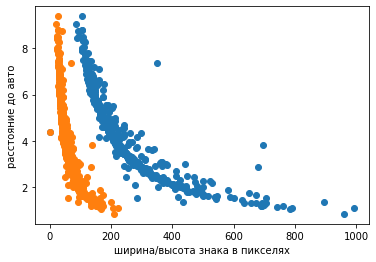

In [17]:
#график зависимости расстояния до автомобиля от ширины знака и высоты
width = pd['width'].to_list()
dist = pd['dist'].to_list()
height = pd['height'].to_list()
plt.plot(width,dist,'o')
plt.plot(height,dist,'o')
plt.xlabel("ширина/высота знака в пикселях")
plt.ylabel("расстояние до авто")
plt.show()

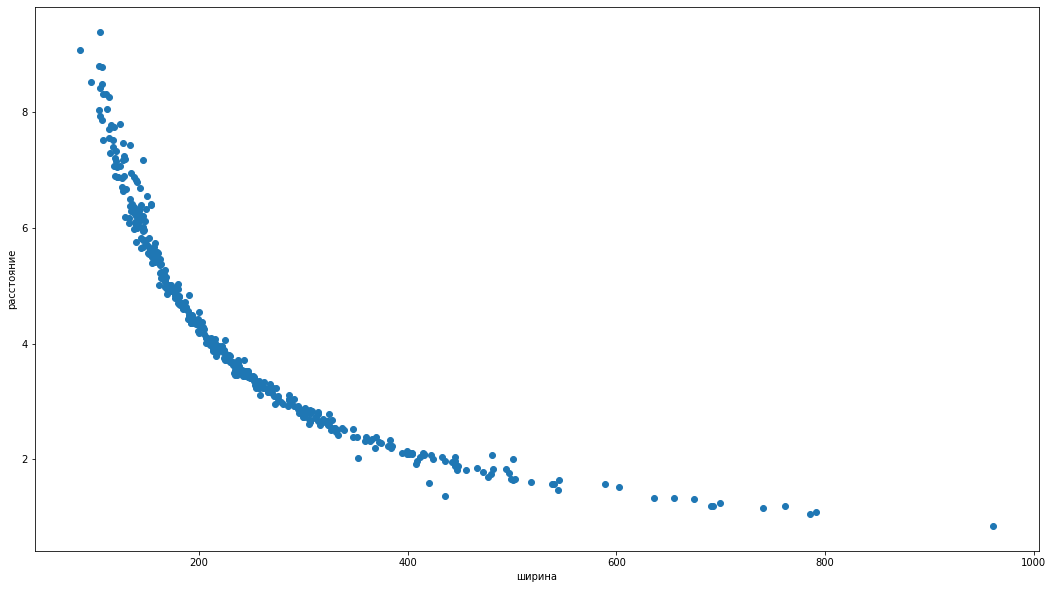

Осталось точек 440 440


In [18]:
#чистим один параметр. длиную сторону номера
#удаляем выбросы квантилями

width = pd['width'].to_list()
dist = pd['dist'].to_list()
ind = []
step = 50 #скользящее окно. С ним можно ЭКСПЕРИМЕНТИРОВАТЬ. Его ширина влияет на количество убитых точек
for i in range(len(width)-step):
    lit = width[i:i+step] 
    
    q1 = np.quantile(lit, 0.25 )
    q3 = np.quantile(lit, 0.75 )
    med = np.median(lit)
    iqr = q3 - q1
    upper_bound = q3 + ( 1.5 * iqr)
    lower_bound = q1 - ( 1.5 * iqr)
    for j in range(i,i+step):
        if (width[j] >upper_bound) or (width[j] < lower_bound):
            ind.append(j)
            #print(j, width[j], dist[j])
            
ind = list(set(ind))
ind.sort()         
ind.reverse()
for i in ind:
    width.pop(i)
    dist.pop(i)
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(width, dist)
 
# x-axis label
ax.set_xlabel('ширина')
 
# y-axis label
ax.set_ylabel('расстояние')
plt.show()
print('Осталось точек', len(width), len(dist))

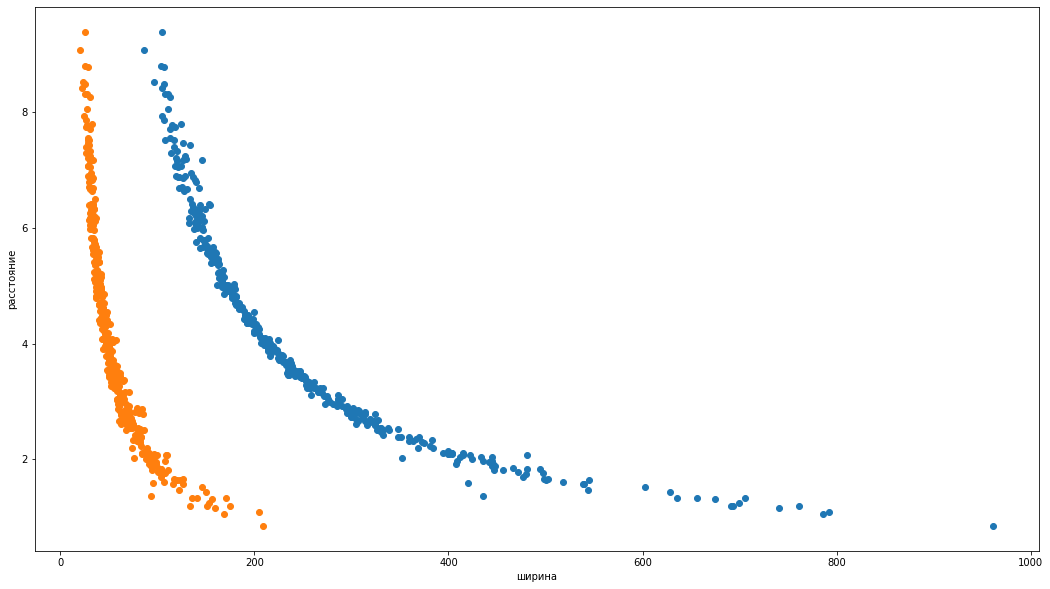

422 422


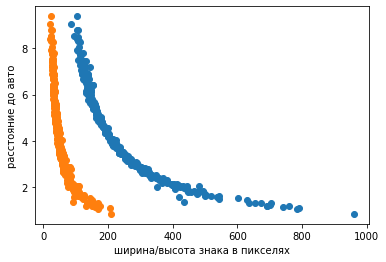

In [19]:
#чистим сразу два параметра таким же спосомбом. Решил, что буду искать зависимость от ширины и высоты знака
width = pd['width'].to_list()
dist = pd['dist'].to_list()
height = pd['height'].to_list()
ind = []
step = 40
for i in range(len(dist)-step):
    lit = width[i:i+step] 
    
    q1 = np.quantile(lit, 0.25 )
    q3 = np.quantile(lit, 0.75 )
    med = np.median(lit)
    iqr = q3 - q1
    upper_bound = q3 + ( 1.5 * iqr)
    lower_bound = q1 - ( 1.5 * iqr)
    for j in range(i,i+step):
        if (width[j] >upper_bound) or (width[j] < lower_bound):
            ind.append(j)
            #print(j, width[j], dist[j])
for i in range(len(dist)-step):
    lit = height[i:i+step] 
    
    q1 = np.quantile(lit, 0.25 )
    q3 = np.quantile(lit, 0.75 )
    med = np.median(lit)
    iqr = q3 - q1
    upper_bound = q3 + ( 1.5 * iqr)
    lower_bound = q1 - ( 1.5 * iqr)
    for j in range(i,i+step):
        if (height[j] >upper_bound) or (height[j] < lower_bound):
            ind.append(j)
            
            
            
ind = list(set(ind))
ind.sort()         
ind.reverse()
for i in ind:
    width.pop(i)
    dist.pop(i)
    height.pop(i)
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(width, dist)
ax.scatter(height, dist)
 
# x-axis label
ax.set_xlabel('ширина')
 
# y-axis label
ax.set_ylabel('расстояние')
plt.show()
print(len(width), len(dist))

plt.plot(width,dist,'o')
plt.plot(height,dist,'o')
plt.xlabel("ширина/высота знака в пикселях")
plt.ylabel("расстояние до авто")
plt.show()

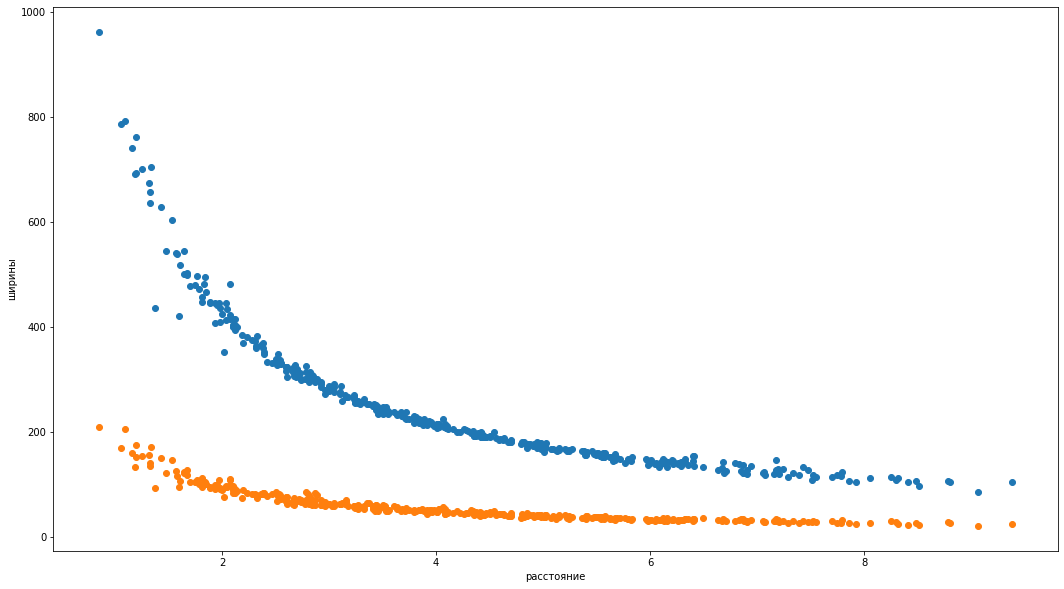

In [20]:
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(dist,width)
ax.scatter(dist,height)
 
# x-axis label
ax.set_xlabel('расстояние')
 
# y-axis label
ax.set_ylabel('ширины')
plt.show()

In [21]:
#эта функция делает апросимацию гиперболой по двум заданным  массивам
def mnkGP(x,y): 
    n=len(x) # количество элементов в списках
    s=sum(y) # сумма значений y
    s1=sum([1/x[i] for i in  range(0,n)]) #  сумма 1/x
    s2=sum([(1/x[i])**2 for i in  range(0,n)]) #  сумма (1/x)**2
    s3=sum([y[i]/x[i]  for i in range(0,n)])  # сумма y/x                   
    a= round((s*s2-s1*s3)/(n*s2-s1**2),3) # коэфициент а с тремя дробными цифрами
    b=round((n*s3-s1*s)/(n*s2-s1**2),3)# коэфициент b с тремя дробными цифрами
    s4=[a+b/x[i] for i in range(0,n)] # список значений гиперболической функции              
    so=round(sum([abs(y[i] -s4[i]) for i in range(0,n)])/(n*sum(y))*100,3)   # средняя ошибка аппроксимации
    plt.title('Аппроксимация гиперболой Y='+str(a)+'+'+str(b)+'/x\n Средняя ошибка--'+str(so)+'%',size=14)
    plt.xlabel('Координата X', size=14)
    plt.ylabel('Координата Y', size=14)
    plt.plot(x, y, color='r', linestyle=' ', marker='o', label='Data(x,y)')
    plt.plot(x, s4, color='g', linewidth=2, label='Data(x,f(x)=a+b/x')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

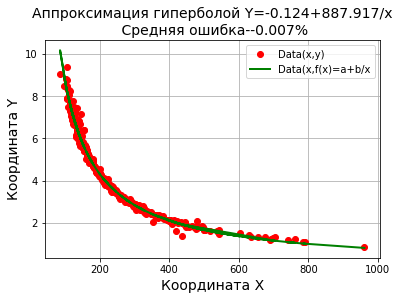

In [22]:
mnkGP(width,dist)

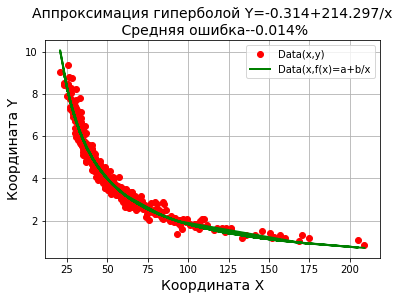

In [23]:
mnkGP(height,dist)

# Полученную формулу используем для обработки тестового датасета 

In [28]:

test = '..\\data_set\\sample_solution.csv'  #здесь будет решение

new_f = 'image_name;distance'  #заголовок для файла

#print(new_f)
not_recognize = []
n = 0
for f in os.listdir(pic_data_test):
    n += 1
    work_file = os.path.join(pic_data_test, f)
    print(n,'работаем  с файлом: ',work_file)
    #ОРИГИНАЛЬНЫЙ ФАЙЛ ТРОГАТ НЕЛЬЗЯ. ИНАЧЕ СОТРЕТСЯ EXIF
    temp_file = f #будем складывать его рядом
    
    if '.heic' in f:
        #temp_file = 'Y:\\tmp.jpg'
        temp_file = 'tmp.jpg'
        conv_heic_to_jpg(work_file, temp_file)
        work_file = temp_file
    
    img = Image.open(work_file)
    img = exif_transpose(img)
    img.save(temp_file)
    
    znak = res(temp_file)
    
    if len(znak) == 3:
        print('ФАЙЛ НЕ РАСПОЗНАН')
        not_recognize.append(f)
        continue
    #формируем строку с параметрами знака для записи в csv
    if 'width' in znak:
        d1 = 888.613 / znak['width'] - 0.129
    else:
        d1 = 0 #не нашли автомобиль
    itog = d1
    #это расчет по высоте, но высота менньше, ошибка больше
    #можно попробовать усреднить
    #d2 = 215.216 / znak['height']  - 0.338
    #itog = (d1+d2)/2
    st = f+';' + str(itog)
        
    new_f = new_f +'\n'+st
    
with open(test, 'w', encoding = 'utf-8') as file:
    file.write(new_f)
print('не распознано файлов', len(not_recognize))
print('не распознанные', *not_recognize)
print('результат сохранен в ', test)

1 работаем  с файлом:  ..\data_set\test\img_1597.jpg
2 работаем  с файлом:  ..\data_set\test\img_1598.jpg
3 работаем  с файлом:  ..\data_set\test\img_1599.jpg
4 работаем  с файлом:  ..\data_set\test\img_1602.jpg
5 работаем  с файлом:  ..\data_set\test\img_1604.jpg
6 работаем  с файлом:  ..\data_set\test\img_1609.jpg
7 работаем  с файлом:  ..\data_set\test\img_1610.jpg
8 работаем  с файлом:  ..\data_set\test\img_1611.jpg
9 работаем  с файлом:  ..\data_set\test\img_1617.jpg
10 работаем  с файлом:  ..\data_set\test\img_1622.jpg
11 работаем  с файлом:  ..\data_set\test\img_1625.jpg
12 работаем  с файлом:  ..\data_set\test\img_1629.jpg
13 работаем  с файлом:  ..\data_set\test\img_1630.jpg
14 работаем  с файлом:  ..\data_set\test\img_1632.jpg
15 работаем  с файлом:  ..\data_set\test\img_1633.jpg
16 работаем  с файлом:  ..\data_set\test\img_1636.jpg
17 работаем  с файлом:  ..\data_set\test\img_1638.jpg
18 работаем  с файлом:  ..\data_set\test\img_1639.jpg
19 работаем  с файлом:  ..\data_set\t

152 работаем  с файлом:  ..\data_set\test\img_2006.jpg
153 работаем  с файлом:  ..\data_set\test\img_2009.jpg
154 работаем  с файлом:  ..\data_set\test\img_2011.jpg
155 работаем  с файлом:  ..\data_set\test\img_2013.jpg
156 работаем  с файлом:  ..\data_set\test\img_2015.jpg
157 работаем  с файлом:  ..\data_set\test\img_2017.jpg
158 работаем  с файлом:  ..\data_set\test\img_2019.jpg
159 работаем  с файлом:  ..\data_set\test\img_2020.jpg
160 работаем  с файлом:  ..\data_set\test\img_2022.jpg
161 работаем  с файлом:  ..\data_set\test\img_2023.jpg
162 работаем  с файлом:  ..\data_set\test\img_2024.jpg
163 работаем  с файлом:  ..\data_set\test\img_2028.jpg
164 работаем  с файлом:  ..\data_set\test\img_2029.jpg
165 работаем  с файлом:  ..\data_set\test\img_2257.jpg
166 работаем  с файлом:  ..\data_set\test\img_2258.jpg
167 работаем  с файлом:  ..\data_set\test\img_2259.jpg
168 работаем  с файлом:  ..\data_set\test\img_2262.jpg
169 работаем  с файлом:  ..\data_set\test\img_2263.jpg
170 работа

301 работаем  с файлом:  ..\data_set\test\img_2518.jpg
302 работаем  с файлом:  ..\data_set\test\img_2521.jpg
303 работаем  с файлом:  ..\data_set\test\img_2522.jpg
304 работаем  с файлом:  ..\data_set\test\img_2523.jpg
305 работаем  с файлом:  ..\data_set\test\img_2524.jpg
306 работаем  с файлом:  ..\data_set\test\img_2525.jpg
307 работаем  с файлом:  ..\data_set\test\img_2526.jpg
308 работаем  с файлом:  ..\data_set\test\img_2529.jpg
309 работаем  с файлом:  ..\data_set\test\img_2530.jpg
310 работаем  с файлом:  ..\data_set\test\img_2531.jpg
311 работаем  с файлом:  ..\data_set\test\img_2532.jpg
312 работаем  с файлом:  ..\data_set\test\img_2534.jpg
313 работаем  с файлом:  ..\data_set\test\img_2537.jpg
314 работаем  с файлом:  ..\data_set\test\img_2540.jpg
315 работаем  с файлом:  ..\data_set\test\img_2541.jpg
316 работаем  с файлом:  ..\data_set\test\img_2542.jpg
317 работаем  с файлом:  ..\data_set\test\img_2543.jpg
318 работаем  с файлом:  ..\data_set\test\img_2545.jpg
319 работа

450 работаем  с файлом:  ..\data_set\test\img_2740.jpg
451 работаем  с файлом:  ..\data_set\test\img_2742.heic
452 работаем  с файлом:  ..\data_set\test\img_2744.jpg
453 работаем  с файлом:  ..\data_set\test\img_2746.jpg
454 работаем  с файлом:  ..\data_set\test\img_2749.jpg
455 работаем  с файлом:  ..\data_set\test\img_2750.heic
456 работаем  с файлом:  ..\data_set\test\img_2752.heic
457 работаем  с файлом:  ..\data_set\test\img_2752.jpg
458 работаем  с файлом:  ..\data_set\test\img_2753.heic
459 работаем  с файлом:  ..\data_set\test\img_2753.jpg
460 работаем  с файлом:  ..\data_set\test\img_2754.jpg
461 работаем  с файлом:  ..\data_set\test\img_2755.heic
462 работаем  с файлом:  ..\data_set\test\img_2756.jpg
463 работаем  с файлом:  ..\data_set\test\img_2757.jpg
464 работаем  с файлом:  ..\data_set\test\img_2758.jpg
465 работаем  с файлом:  ..\data_set\test\img_2759.jpg
466 работаем  с файлом:  ..\data_set\test\img_2761.jpg
467 работаем  с файлом:  ..\data_set\test\img_2762.jpg
468 р